# DataLab Cup 3: Reverse Image Caption

# Download Dataset from Kaggle

In [ ]:
# Follow the tutorial in this page:
# https://www.endtoend.ai/tutorial/how-to-download-kaggle-datasets-on-ubuntu/
!cat ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c datalab-cup3-reverse-image-caption-2021

In [ ]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall('./')

file_path = './datalab-cup3-reverse-image-caption-2021.zip'
zip_list(file_path)

# Libraries and Packages Import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable warnings, info and errors 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path
from tqdm import tqdm

import re
from IPython import display

In [2]:
!nvidia-smi

Thu Jan  6 14:19:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8    10W / 250W |     16MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Restrict TensorFlow to only use the first GPU
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

#         # Currently, memory growth needs to be the same across GPUs
#         #for gpu in gpus:
#         #    tf.config.experimental.set_memory_growth(gpu, True)
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

# Preprocessing

## Preprocess text

In [4]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


# BERT Embedding

In [5]:
# def idx2word(indices_list):
#     results_list = []
#     for indices in indices_list:
#         string = ''
#         length_of_string = 0
#         for idx in indices:
#             if idx == '5428':
#                 string = string + ''
#             elif idx == '5427':
#                 break
#             else:
#                 string = string + id2word_dict[idx] + ' '
#         results_list.append(string.strip())
#     return results_list

# def remove_empty_string(string_list):
#     empty_flag = False
#     for string in string_list:
#         if string == '':
#             empty_flag = True
#             break
#     if empty_flag == False:
#         return string_list
#     else:
#         new_string_list = []
#         for string in string_list:
#             if string != '':
#                 new_string_list.append(string)
#         return new_string_list

In [6]:
# from transformers import BertTokenizer, TFBertModel

# bert_tokenizer = BertTokenizer.from_pretrained(
#     'bert-large-uncased', 
#     do_lower_case=False,
#     do_basic_tokenize=False
# )
# bert_model = TFBertModel.from_pretrained('bert-large-uncased')

In [7]:
# def turn_to_bert_embedding(string_list):
#     try:
#         bert_inputs = bert_tokenizer(string_list, return_tensors="tf", padding='max_length',max_length=30)
#         bert_outputs = bert_model(bert_inputs)
#         caption_embedding = bert_outputs.last_hidden_state[:,0]
#     except(ValueError):
#         print(string_list)
#     return caption_embedding.numpy().tolist()

# test_string = ['this flower is white and pink in color with petals that have small veins',
#                'the flower shown has a purple and white petal with white anther', 
#                'the four heart shaped pink petals of this flower are striped with fuchsia and their centers are yellow and white']  
# print(len(turn_to_bert_embedding(test_string)[0]))

In [8]:
# BERT_EMBEDDING_FILE = './dataset/bert_embedding.pkl'

In [9]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


## Dataset - Run Once

In [10]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [11]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [12]:
# df.loc[0,'texts']

In [13]:
# df['texts'] = df['texts'].apply(lambda x: remove_empty_string(x))

In [14]:
# df.head(5)

In [15]:
# def count_caption_num(string_list):
#     return len(string_list)

# df['caption_num'] = df['texts'].apply(lambda c: count_caption_num(c))

In [16]:
# num_dict = {}
# for num in df['caption_num'].tolist():
#     if num in num_dict:
#         num_dict[num]+=1
#     else:
#         num_dict[num]=1
# num_dict

In [17]:
# df['embeddings'] = df['texts'].apply(lambda x : turn_to_bert_embedding(x))
# len(df.loc[0,'embeddings'][0])

In [18]:
# df.to_pickle(BERT_EMBEDDING_FILE)

In [19]:
# # No need to run this cell (run inside dataset_generator())
# df_bert = pd.read_pickle(BERT_EMBEDDING_FILE)

# embeddings = df_bert['embeddings'].values
# embedding = []

# for i in range(len(embeddings)):
#     for emb in embeddings[i]:
#         embedding.append(emb)
# embedding = np.asarray(embedding)
# embedding.shape[0]

In [20]:
# data_path = './dataset'
# df = pd.read_pickle(data_path + '/text2ImgData.pkl')
# num_training_sample = len(df)
# n_images_train = num_training_sample
# print('There are %d image in training data' % (n_images_train))

# Data Augmentation

Reference: https://mmuratarat.github.io/2019-02-28/data-augmentation-in-tensorflow

In [21]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3
MAPPING_FUNC = None

def vertical_flip(tf_img):
    return tf.image.flip_left_right(tf_img)

def horizontal_flip(tf_img):
    return tf.image.flip_up_down(tf_img)

def brightness(tf_img):
    return tf.image.random_brightness(tf_img, 0.2, 2)

def data_generator(caption, image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    # img = tf.image.convert_image_dtype(img, tf.float32)
    # img = tf.image.per_image_standardization(img)
    img.set_shape([None, None, 3])
    
    if MAPPING_FUNC is not None:
        img = MAPPING_FUNC(img)

    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    caption = tf.cast(caption, tf.int32)    
    return img, caption

def transform_dataset(caption, image_path):
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption))
    return dataset

def dataset_generator(filenames, batch_size):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    caption = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in range(len(captions)):
        caption.append(random.choice(captions[i]))
    caption = np.asarray(caption)
    caption = caption.astype(np.int64)
    image_path = df['ImagePath'].values
    
    # assume that each row of features corresponds to the same row as labels.
    assert caption.shape[0] == image_path.shape[0]
    
    original_dataset = transform_dataset(caption, image_path)

    MAPPING_FUNC = vertical_flip
    vertical_dataset = transform_dataset(caption, image_path)

    MAPPING_FUNC = horizontal_flip
    horizontal_dataset = transform_dataset(caption, image_path)

    MAPPING_FUNC = brightness
    brightness_dataset = transform_dataset(caption, image_path)
    
    dataset = original_dataset.concatenate(vertical_dataset)
    dataset = dataset.concatenate(horizontal_dataset)
    dataset = dataset.concatenate(brightness_dataset)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [22]:
# also can go 256
BATCH_SIZE = 64 
dataset = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE)
len(dataset)

460

# Hyperparameters

In [23]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 2000,
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/demo',  # checkpoint path
    'PRINT_FREQ': 1                           # printing frequency of loss
}

# Conditioinal GAN Model

## Text Encoder

In [24]:
class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text, which is a list of ids
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        
        # embedding with tensorflow API
        self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        # RNN, here we use GRU cell, another common RNN cell similar to LSTM
        self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')

        # self.bidirect = layers.Bidirectional(layers.LSTM(128))
        # self.d1 = layers.Dense(128, activation="relu")
    
    def call(self, text, hidden):
        text = self.embedding(text)
        output, state = self.gru(text, initial_state = hidden)
        return output[:, -1, :], state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

## Generator

In [25]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d2 = tf.keras.layers.Dense(64*64*3)

        self.d3 = layers.Dense(8*8*512, use_bias=False)
        self.bn1= layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.5)

        self.Conv2DTrans1 = layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding="same", use_bias=False)
        self.Conv2DTrans2 = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False)
        self.Conv2DTrans3 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False)
        self.Conv2DTrans4 = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding="same", use_bias=False)
        
    def call(self, text, noise_z):
        text = self.flatten(text)
        text = self.d1(text)
        text = tf.nn.leaky_relu(text)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        text_concat = self.d3(text_concat)
        text_concat = self.bn1(text_concat)
        text_concat = tf.reshape(text_concat, [-1, 8, 8, 512])
        
        text_concat = self.Conv2DTrans1(text_concat)
        text_concat = self.bn2(text_concat)
        text_concat = tf.nn.leaky_relu(text_concat)
        text_concat = self.dropout(text_concat)

        text_concat = self.Conv2DTrans2(text_concat)
        text_concat = self.bn3(text_concat)
        text_concat = tf.nn.leaky_relu(text_concat)
        text_concat = self.dropout(text_concat)

        text_concat = self.Conv2DTrans3(text_concat)
        text_concat = self.bn4(text_concat)
        text_concat = tf.nn.leaky_relu(text_concat)
        text_concat = self.dropout(text_concat)

        text_concat = self.Conv2DTrans4(text_concat)

        logits = tf.reshape(text_concat, [-1, 64, 64, 3])
        output = tf.nn.tanh(logits)

        return logits, output

## Discriminator

In [26]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d_img = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d = tf.keras.layers.Dense(1)

        self.Conv2D1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same")
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.3)

        self.Conv2D2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")
        self.Conv2D3 = layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same")

    def call(self, img, text):
        text = self.flatten(text)
        text = self.d_text(text)
        text = tf.nn.leaky_relu(text)
        
        img = self.Conv2D1(img)
        img = tf.nn.leaky_relu(img)
        img = self.dropout(img)

        img = self.Conv2D2(img)
        img = tf.nn.leaky_relu(img)
        img = self.dropout(img)

        img = self.Conv2D3(img)
        img = tf.nn.leaky_relu(img)
        img = self.dropout(img)

        img = self.flatten(img)
        img = self.d_img(img)
        
        # concatenate image with paired text
        img_text = tf.concat([text, img], axis=1)
        
        logits = self.d(img_text)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [27]:
text_encoder = TextEncoder(hparas) #if you use BERT to encode, then no need run this text_encoder
generator = Generator(hparas)
discriminator = Discriminator(hparas)

## Training Settings

In [28]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
def discriminator_loss(real_logits, fake_logits):
    # output value of real image should be 1
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.SGD(hparas['LR'])

In [31]:
# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_name = 'ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

last_ckp = tf.train.latest_checkpoint(checkpoint_dir)
# print(last_ckp)
if last_ckp:
    init_epoch = int(last_ckp.split("-")[-1])+1
    print(f'Resume training from epoch {init_epoch-1}')
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 epoch=tf.Variable(init_epoch-1))
    checkpoint.restore(last_ckp)
else:
    init_epoch=1
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 epoch=tf.Variable(init_epoch-1))

manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=10,
                                     checkpoint_name=checkpoint_name)

Resume training from epoch 378


In [32]:
@tf.function
def DC_DTrain(image, caption, hidden, noise):
    # z = tf.random.normal(hparas['BZ'])
    noise_g = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_gp:
            text_embed, hidden = text_encoder(caption, hidden)
            # _, fake_image = generator(text_embed, noise)
            # real_logits, real_output = discriminator(image, text_embed)
            # fake_logits, fake_output = discriminator(fake_image, text_embed)

            _, x_bar = generator(text_embed, noise_g, training = True)
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = image
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            x_bar = x_bar + noise * tf.random.normal(x_bar.shape)
            x = x + noise * tf.random.normal(x.shape)
            x_hat = x_hat + noise * tf.random.normal(x_hat.shape)

            z0, _ = discriminator(x_bar, text_embed, training = True)
            z1, _ = discriminator(x, text_embed, training = True)
            z2, _ = discriminator(x_hat, text_embed, training = True)

            gradient_penalty = tp_gp.gradient(z2,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_d = tp.gradient(ld, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradient_d, discriminator.trainable_variables))

    return lg, ld

@tf.function
def DC_GTrain(image, caption, hidden, noise):
    # z = tf.random.normal(hparas['BZ'])
    noise_g = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_gp:
            text_embed, hidden = text_encoder(caption, hidden)
            # _, fake_image = generator(text_embed, noise)
            # real_logits, real_output = discriminator(image, text_embed)
            # fake_logits, fake_output = discriminator(fake_image, text_embed)

            _, x_bar = generator(text_embed, noise_g, training = True)
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = image
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            x_bar = x_bar + noise * tf.random.normal(x_bar.shape)
            x = x + noise * tf.random.normal(x.shape)
            x_hat = x_hat + noise * tf.random.normal(x_hat.shape)

            z0, _ = discriminator(x_bar, text_embed, training = True)
            z1, _ = discriminator(x, text_embed, training = True)
            z2, _ = discriminator(x_hat, text_embed, training = True)

            gradient_penalty = tp_gp.gradient(z2,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_g = tp.gradient(lg, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_g, generator.trainable_variables))

    return lg, ld

In [33]:
# text_encoder version
@tf.function
def test_step(caption, noise, hidden):
    text_embed, hidden = text_encoder(caption, hidden)
    _, fake_image = generator(text_embed, noise)
    return fake_image


# BERT version
# @tf.function
# def test_step(embedding, noise, hidden):
#     # text_embed, hidden = text_encoder(caption, hidden)
#     _, fake_image = generator(embedding, noise)
#     return fake_image

In [34]:
DC_Train = (
    DC_DTrain,
    DC_DTrain,
    DC_DTrain,
    DC_DTrain,
    DC_DTrain,
    DC_GTrain,
)

DC_Critic = len(DC_Train)

## Visulization

In [35]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [36]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int64)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [37]:
# def bert_sample_generator(embedding, batch_size):
#     embedding = np.asarray(embedding)
#     embedding = embedding.astype(np.float32)
#     dataset = tf.data.Dataset.from_tensor_slices(embedding)
#     dataset = dataset.batch(batch_size)
#     return dataset

In [38]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)
sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])

# bert_sample_sentence *= 2
# for i, sent in enumerate(bert_sample_sentence):
#     bert_sample_sentence[i] = turn_to_bert_embedding(sent)
# bert_sample_sentence = bert_sample_generator(bert_sample_sentence, hparas['BATCH_SIZE'])

# Training

In [39]:
if not os.path.exists('samples/demo'):
    os.makedirs('samples/demo')

In [40]:
def train(dataset, epochs):
    # hidden state of RNN
    hidden = text_encoder.initialize_hidden_state()
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    
    ctr = 0
    for epoch in range(hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
        if epoch < 200:
            noise = 1.0 / float(epoch + 1)
        else:
            noise = 0.0
        
        for image, caption in dataset:
            lg, ld = DC_Train[ctr](image, caption, hidden, noise) # (real_img, embed, noise_decay)
            ctr += 1
            g_total_loss += lg.numpy()
            d_total_loss += ld.numpy()
            if ctr == DC_Critic : ctr = 0
            
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
            
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                     g_total_loss/steps_per_epoch,
                                                                     d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
        
        # save the model
        # if (epoch + 1) % 50 == 0:
        #     checkpoint.save(file_prefix = checkpoint_prefix)
        save_path = manager.save()
        print("Saved checkpoint for epoch {}: {}".format(epoch, save_path))
        
        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step(caption, sample_seed, hidden)
            save_images(fake_image, [ni, ni], 'samples/demo/train_{:02d}.jpg'.format(epoch))

In [ ]:
train(dataset, hparas['N_EPOCH'])

In [28]:
print(len(dataset))

460


# Evaluation

## Testing Dataset
If you change anything during preprocessing of training dataset, you must make sure same operations have be done in testing dataset.

In [41]:
# checkpoint_dir = "checkpoints/demo"
# checkpoint.restore(checkpoint_dir + '/ckpt-378')

In [42]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./dataset/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int64)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [43]:
# def testing_data_generator(embedding, index):
#     embedding = tf.cast(embedding, tf.float32)
#     return embedding, index

# def testing_dataset_generator(data, batch_size, data_generator):
#     embeddings = data['embeddings'].values
#     embedding = []
#     for i in range(len(embeddings)):
#         embedding.append(embeddings[i])
#     embedding = np.asarray(embedding)
#     embedding = embedding.astype(np.float32)

#     index = data['ID'].values
#     index = np.asarray(index)
    
#     assert embedding.shape[0] == index.shape[0]

#     dataset = tf.data.Dataset.from_tensor_slices((embedding, index))
#     dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     dataset = dataset.repeat().batch(batch_size)
    
#     return dataset

In [44]:
def idx2word_test(indices_list):
    indices_list = [indices_list]
    results_list = []
    for indices in indices_list:
        string = ''
        length_of_string = 0
        for idx in indices:
            if idx == '5428':
                string = string + ''
            elif idx == '5427':
                break
            else:
                string = string + id2word_dict[idx] + ' '
        results_list.append(string.strip())
    return results_list

In [45]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)

In [46]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values
# data['texts'] = data['Captions'].apply(lambda x: idx2word_test(x))
# data['texts'] = data['texts'].apply(lambda x: remove_empty_string(x))
# data['embeddings'] = data['texts'].apply(lambda x : turn_to_bert_embedding(x))
# captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

## Inference

In [47]:
def inference(dataset):
    # hidden = text_encoder.initialize_hidden_state()
    hidden = None
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for embedding, idx in dataset:
        if step > EPOCH_TEST:
            break
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image  = test_step(embedding, sample_seed, hidden)
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image1 = test_step(embedding, sample_seed, hidden)
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image2 = test_step(embedding, sample_seed, hidden)
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image3 = test_step(embedding, sample_seed, hidden)
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        fake_image4 = test_step(embedding, sample_seed, hidden)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]),   fake_image[i].numpy()*0.5 + 0.5)
            plt.imsave('./inference/our_inference/inference_{:04d}_1.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            plt.imsave('./inference/our_inference/inference_{:04d}_2.jpg'.format(idx[i]), fake_image1[i].numpy()*0.5 + 0.5)
            plt.imsave('./inference/our_inference/inference_{:04d}_3.jpg'.format(idx[i]), fake_image2[i].numpy()*0.5 + 0.5)
            plt.imsave('./inference/our_inference/inference_{:04d}_4.jpg'.format(idx[i]), fake_image3[i].numpy()*0.5 + 0.5)
            plt.imsave('./inference/our_inference/inference_{:04d}_5.jpg'.format(idx[i]), fake_image4[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [48]:
inference(testing_dataset)

Time for inference is 31.3629 sec


## Output score.csv
CAUTION: 
* Please modify GPU setting in <i>inception_score.py</i> if need.
* Please run the below cmd in command line.

In [ ]:
!cd testing
!python inception_score.py ../inference/demo ../score_demo.csv 39 # BATCH_SIZE=39 is available using GTX 1080 Ti (need 9441MB memory)

In [49]:
def visualize(idx):
    fig = plt.figure(figsize=(14,14))
    
    for count, i in enumerate(idx):
        loc = np.where(i==index)[0][0]
        text = ''
        for word in captions[loc]:
            if id2word_dict[word] != '<PAD>':
                text += id2word_dict[word]
                text += ' '
        print(text)
        for j in range(len(idx)):
            path  = './inference/our_inference/inference_{:04d}_{:d}.jpg'.format(i,j+1)
            fake_image = plt.imread(path)

            plt.subplot(5, 5, count*5+j+1)
            plt.imshow(fake_image)
            
            plt.axis('off')

In [50]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


this flower is pink and white in color with petals that are oval shaped 
this is a small flower with yellow petals and orange near the ovary 
this flower is pink and yellow in color with petals that are oval shaped 
this flower is yellow and white in color with petals that are oval shaped 
a flower with ragged white and purple petals and with a cluster of white stamen 


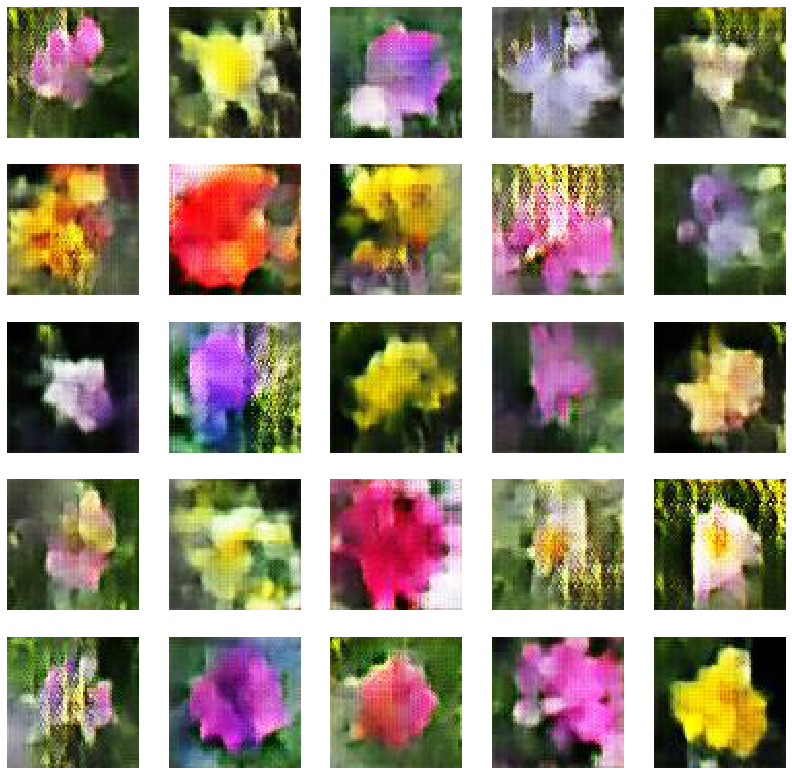

In [74]:
import pandas as pd
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values
index = data['ID'].values
random_idx = [253, 267, 413, 841, 3462]

visualize(random_idx)